# Regression and SHAP

We will use 

- a generalized linear model (GLM),
- a boosted tree, and
- a deep neural net

to predict diamonds prices and interprete these models with [SHAP](https://github.com/slundberg/shap). All model techniques will be optimized against Gamma loss, a natural loss function for right skewed data with light tails - perfect for diamonds prices.

## Load and describe data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from plotnine.data import diamonds
from plotnine import *
import warnings
warnings.simplefilter('ignore')

In [4]:
nums = ['price', 'carat']
cats = ['cut', 'color', 'clarity']

diamonds.describe()

carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53940.000000  53940.000000  
mean       5.734526      3.538734  
std        1.142135      0.705699  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       58.900000     31.800000

### Univariate description

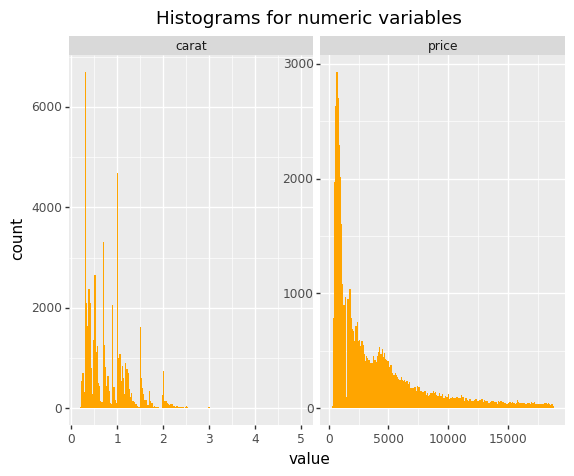

<ggplot: (117759745449)>


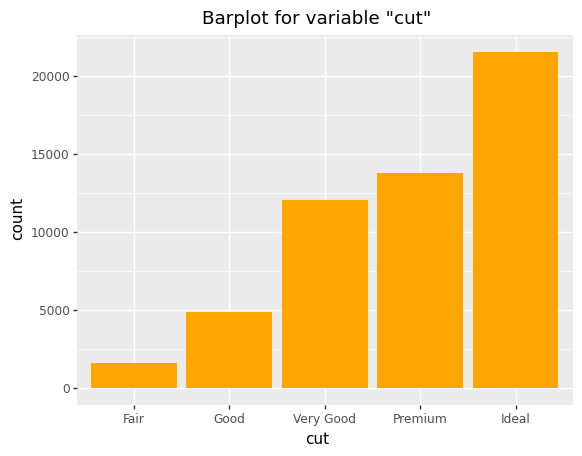

<ggplot: (117780889185)>


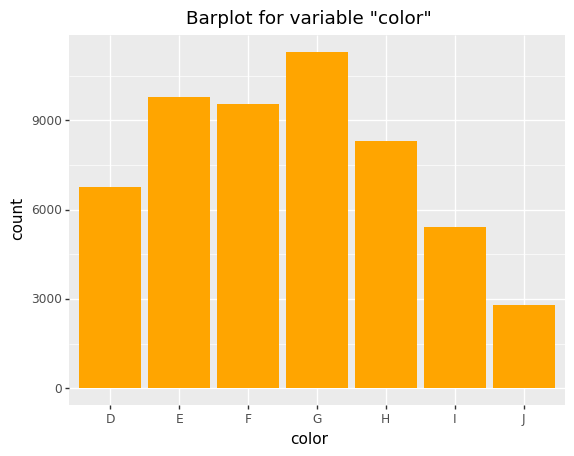

<ggplot: (117780939144)>


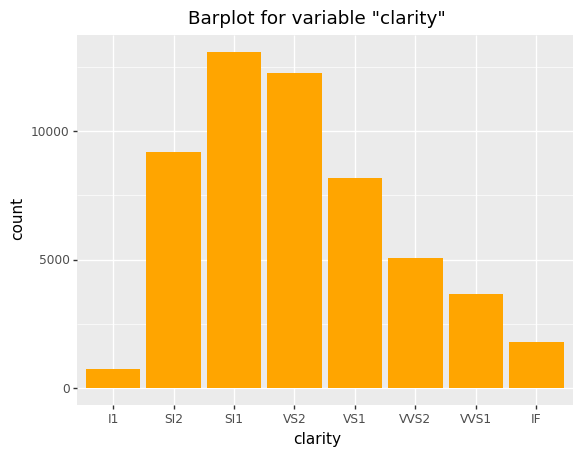

<ggplot: (117782627524)>


In [3]:
print(ggplot(aes(x='value'), data=diamonds[nums].melt()) 
      + geom_histogram(fill='orange') 
      + facet_wrap('~variable', scales='free')
      + ggtitle('Histograms for numeric variables'))

for i, cat in enumerate(cats):
    print(ggplot(aes(x=cat), data=diamonds) 
          + geom_bar(fill='orange')
          + ggtitle(f'Barplot for variable "{cat}"'))

### Associations between price and other variables

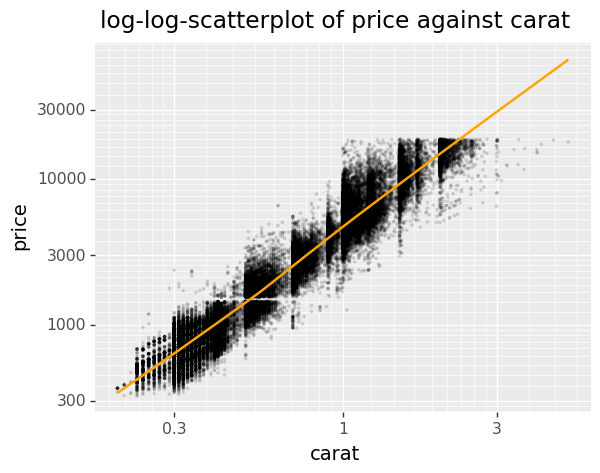

<ggplot: (161956358970)>


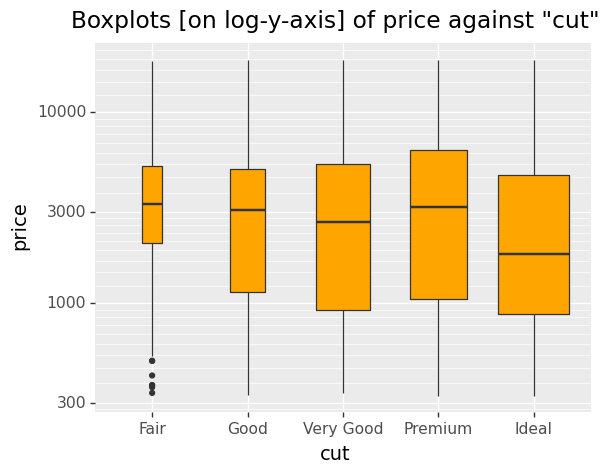

<ggplot: (161956359096)>


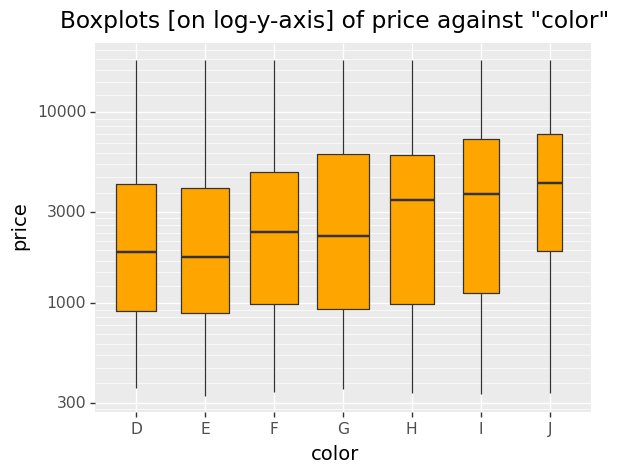

<ggplot: (161956261160)>


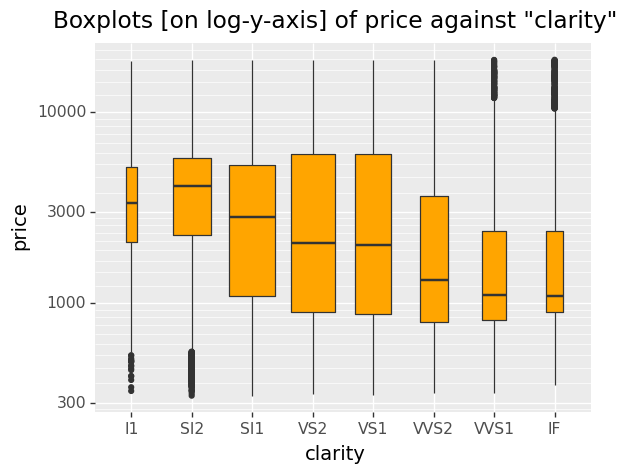

<ggplot: (161956261367)>


In [53]:
print(ggplot(aes(x='carat', y='price'), data=diamonds) 
      + geom_point(alpha=0.1, shape='.')
      + geom_smooth(color='orange', method='lowess')
      + scale_y_log10()
      + scale_x_log10()
      + ggtitle('log-log-scatterplot of price against carat')
      + theme_gray(base_size=14))

for i, cat in enumerate(cats):
    print(ggplot(aes(x=cat, y='price'), data=diamonds) 
          + geom_boxplot(fill='orange', varwidth=True)
          + scale_y_log10()
          + ggtitle(f'Boxplots [on log-y-axis] of price against "{cat}"')
          + theme_gray(base_size=14))

## Modeling

### Strategy

Our modeling strategy is the following:

1. Create "interpretable" features, i.e. categoricals instead of OHE or integer encoded factors, no polynomials etc. Specifically, we will apply a log-transformation of `carat`. In order to compare SHAP interpretations across models, this step is common for all modeling techniques.
2. Train/test split.
3. Since our data set contains categorical columns and the `shap` package cannot deal with these, we create a numeric copy.
3. Wrap model specific transformations in preprocessor functions/pipelines
    - GLM: Dummy coding of `cut`, `color`, and `clarity`.
    - Boosted trees: No additional preprocessing required.
    - Deep neural net: Split of data into a dict of numpy arrays. One with the only dense feature `log_carat`, each other (`cut`, `color`, and `clarity`) in one-dimensional integer arrays to be used in embedding layers.
4. Fit the models.
    - GLM: using Gamma regression, a special case of Scikit-learn's [TweedieRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html).
    - Boosted trees: using [LightGBM](https://github.com/microsoft/LightGBM) with optimized parameters obtained by 5-fold cross-validation and GridSearch.
    - Deep neural net: using [Keras](https://github.com/keras-team/keras) with Tensorflow 2.0 backend and early stopping on internal 20% validation data.
5. Compare and interprete the models.
    - Performance: by comparing gamma deviances on the test data set.
    - Variable importance: by studying SHAP importances.
    - Effects: by looking at SHAP dependence plots.

### Create "interpretable" features

In [6]:
prep = (diamonds[nums + cats]
      .assign(log_carat=np.log(diamonds.carat))
      .drop(["carat"], axis=1))
prep.head()

price      cut color clarity  log_carat
0    326    Ideal     E     SI2  -1.469676
1    326  Premium     E     SI1  -1.560648
2    327     Good     E     VS1  -1.469676
3    334  Premium     I     VS2  -1.237874
4    335     Good     J     SI2  -1.171183

### Train/test split

In [7]:
from sklearn.model_selection import train_test_split

y = prep["price"]
X = prep.drop("price", axis=1)

y_train, y_test, X_train_display, X_test_display = train_test_split(
    y, X, train_size=0.8, random_state=2098
)

### Map to numeric data

In [8]:
def cat2num(df):
    df = df.copy()
    cat_vars = df.select_dtypes("category").columns
    df[cat_vars] = df[cat_vars].apply(lambda x: x.cat.codes)
    return df

X_train = cat2num(X_train_display)
X_test = cat2num(X_test_display)
X_train

cut  color  clarity  log_carat
1937     1      1        1  -0.105361
43110    4      2        2  -0.616186
50408    4      6        3  -0.261365
50405    3      1        1  -0.314711
34551    4      2        3  -0.967584
...    ...    ...      ...        ...
16336    2      2        3   0.009950
30788    4      1        5  -1.203973
20145    3      3        4   0.182322
30350    4      5        5  -0.916291
53938    3      4        1  -0.150823

[43152 rows x 4 columns]

### Model specific transformations and fits

#### GLM

In [9]:
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessor
prep_glm = ColumnTransformer(transformers=[
    ("ohe", OneHotEncoder(drop='first'), [0, 1, 2])
], remainder='passthrough')
    
# Full pipeline with predictor on top of the preprocessor
glm = Pipeline(steps=[ 
    ('prep_glm', prep_glm),
    ('model', TweedieRegressor(power=2, alpha=0, link='log'))
]) 

# Fit
glm.fit(X_train, y_train)

Pipeline(steps=[('prep_glm',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  [0, 1, 2])])),
                ('model', TweedieRegressor(alpha=0, link='log', power=2))])

#### Gradient boosted trees

We tune parameters of LightGBM by a RandomizedGridSearch customized for early stopping.

In [10]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, 
                     label=y_train, 
                     free_raw_data=False)

# Optional tuning
if False:
    from sklearn.model_selection import ParameterSampler, ParameterGrid
    
    # Final narrow grid
    grid = ParameterSampler({
        "learning_rate": [0.02],
        "num_leaves": [20, 30, 40],
        'min_child_samples': [10, 15, 20],
        'reg_alpha': [0, 1, 2],
        'reg_lambda': [0, 1],
        'min_split_gain': [0, 0.001],
        'subsample': [0.9, 1],
        'bagging_freq': [1],
        'colsample_bytree': [1],
        'colsample_bynode': [1],
        "verbose": [2],
        "objective": ["gamma"],
        "metric": ["gamma_deviance"]
    }, n_iter=10)
    
    gridsearch_results = pd.DataFrame(columns=[0, 1, 2])

    print("We are iterating through grid of size", len(grid))
    for g in grid:
        cv_results = lgb.cv(
            g,
            dtrain,
            num_boost_round=10000,
            nfold=5,
            stratified=False,
            early_stopping_rounds=20)
        perf = cv_results['gamma_deviance-mean']
        new_row = {"params": [g], "num_boost_round": len(perf), "perf": perf[-1]}
        gridsearch_results = gridsearch_results.append(new_row, ignore_index=True)  
        gridsearch_results.to_json("regression_gamma_shap/gridsearch_diamonds.txt")
        
# Load tuning grid results
gridsearch_results = pd.read_json("regression_gamma_shap/gridsearch_diamonds.txt")
gridsearch_results.sort_values("perf", inplace=True)
gridsearch_results.head()
best = gridsearch_results.iloc[0]

# Fit on best params
gbm = lgb.train(best.params[0], 
                train_set=dtrain, 
                num_boost_round=best.num_boost_round)

### Keras neural net

In [103]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Embedding, concatenate, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Preprocessor (no column names allowed due to internals of SHAP)
def prep_nn(df):
    xx = df.copy()
    if isinstance(xx, pd.DataFrame):
        xx = df.to_numpy()
    return {'dense1': xx[:, 3],
            'cut': xx[:, 0],
            'color': xx[:, 1],
            'clarity': xx[:, 2]}

# Gamma loss (up to scaling and constants)
def loss_gamma(y_true, y_pred):
    return -K.log(y_true / y_pred) + y_true / y_pred

# Neural net structure
def create_model(lr=0.001):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
  
    # Dense input
    dense_input = Input(shape=(1, ), name='dense1')

    # Embedding input
    cut_input = Input(shape=(1, ), name='cut')
    color_input = Input(shape=(1, ), name='color')
    clarity_input = Input(shape=(1, ), name='clarity')
    
    cut_emb = Flatten()(Embedding(5, 1)(cut_input))
    color_emb = Flatten()(Embedding(7, 1)(color_input))
    clarity_emb = Flatten()(Embedding(8, 1)(clarity_input))
    
    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, cut_emb, color_emb, clarity_emb])
    x = Dense(20, activation="tanh")(x)
    x = Dense(15, activation="tanh")(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="exponential", name='output')(x)

    inputs = {"dense1": dense_input, 
              "cut": cut_input, 
              "color": color_input, 
              "clarity": clarity_input}

    # Connect input and output
    model = Model(inputs, outputs)

    model.compile(loss=loss_gamma,
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

# Early stopping if validation performance does not improve for five rounds
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, mode='min')

# Plot history
def plot_history(h, drop_m=0):
    h = pd.DataFrame(h.history)
    h['epoch'] = np.arange(len(h)) + 1
    h = h.iloc[drop_m:]
    h = h.melt(id_vars='epoch', var_name='Data', value_name='Loss')
    print(ggplot(aes(x='epoch', y='Loss', group='Data', color='Data'), h)
          + geom_line()
          + theme_gray(base_size=14))

**Fit model**

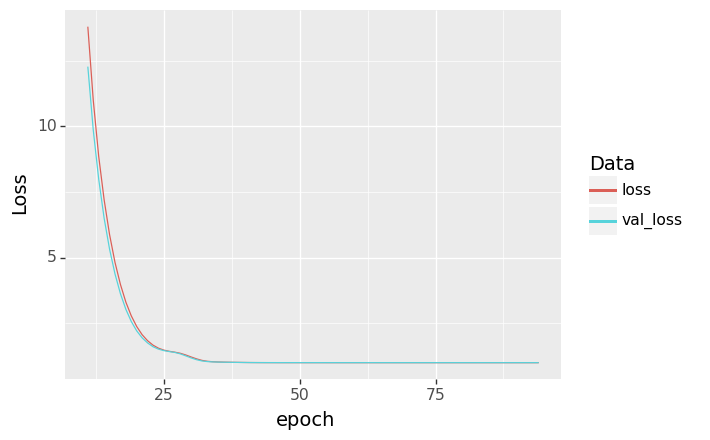

<ggplot: (161965590652)>


In [104]:
nn = create_model(0.0005)

history = nn.fit(prep_nn(X_train), 
                 y_train,
                 batch_size=1000,
                 epochs=100,
                 shuffle=True,
                 validation_split=0.2,
                 callbacks=[early_stop], 
                 verbose=False)

plot_history(history, 10)

## Compare and interprete models

### Performance

We will first compare our models by evaluating Gamma deviance on the test data set.

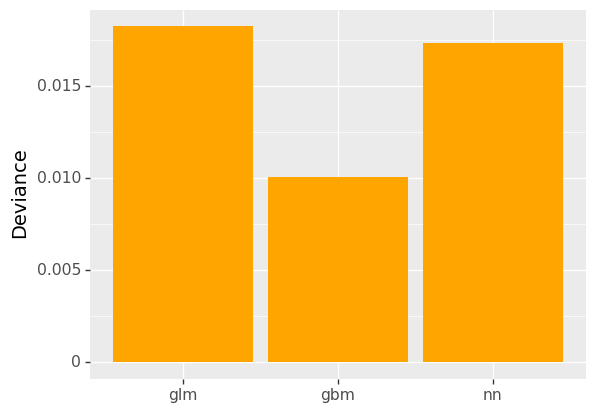

<ggplot: (161956237186)>

In [51]:
from sklearn.metrics import mean_gamma_deviance as deviance

deviances = {'glm': [deviance(glm.predict(X_test), y_test)],
             'gbm': [deviance(gbm.predict(X_test), y_test)],
             'nn': [deviance(nn.predict(prep_nn(X_test)), y_test)]}
(ggplot(pd.DataFrame(deviances).melt(value_name='Deviance'), aes(x='factor(variable, ("glm", "gbm", "nn"))', y='Deviance')) 
 + geom_bar(stat='identity', fill='orange')
 + labs(x='')
 + theme_gray(base_size=14))

### Calculate SHAP values for all models

Takes 2-3 minutes, mainly due to `KernelExplainers`.

In [18]:
import shap
shap.initjs()

# Number of SHAP decompositions
N_SHAP = 1000

# Background data size for KernelExplainer
K = 500

# Map predictions of GLM and NN to log scale to match the scale of treeSHAP
def pred_glm_log(X):
    return np.log(glm.predict(X))

def pred_nn_log(X):
    return np.log(nn.predict(prep_nn(X), batch_size=1000).flatten())

# Initialize explainer
explainers = {
    'glm': shap.KernelExplainer(pred_glm_log, data=shap.sample(X_train, K)),
    'gbm': shap.TreeExplainer(gbm),
    'nn': shap.KernelExplainer(pred_nn_log, data=shap.sample(X_train, K))
}

# Calculate N_SHAP decompositions
shap_values = {k: v.shap_values(X_train[:N_SHAP]) for k, v in explainers.items()}

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


### SHAP importances on log-scale

Note that SHAP importances are as good or bad as the model.

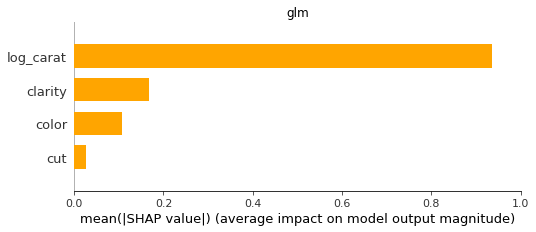

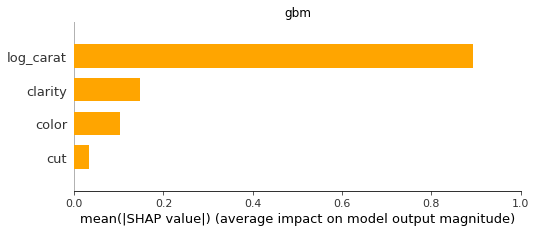

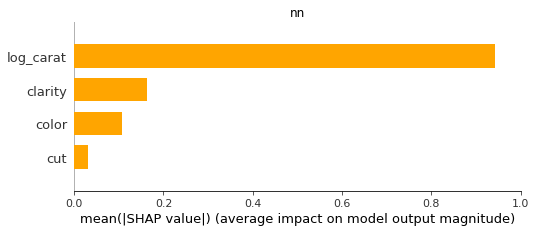

In [22]:
for k, v in shap_values.items():
    shap.summary_plot(v, X_train[:N_SHAP], plot_type="bar", color="orange", show=False)
    plt.xlim(0, 1)
    plt.title(k)
    plt.show()

### Dependence plots on log-scale

Note that SHAP dependence plots are as good or bad as the model.

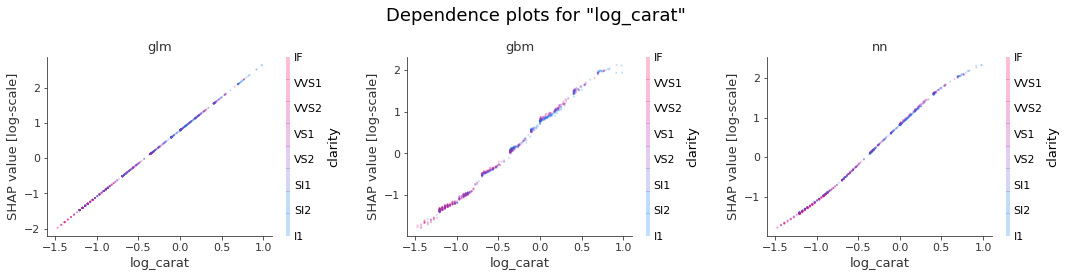

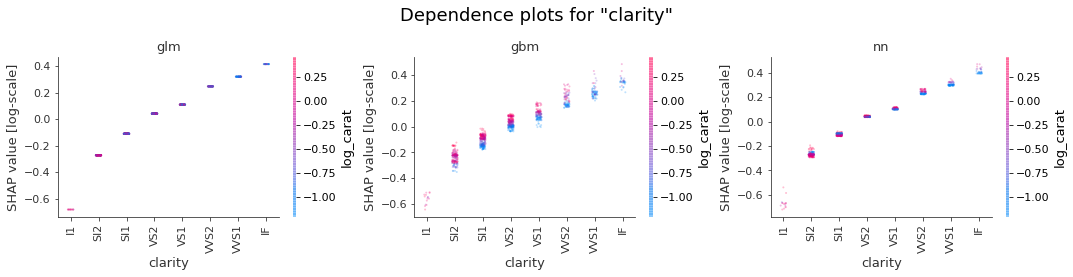

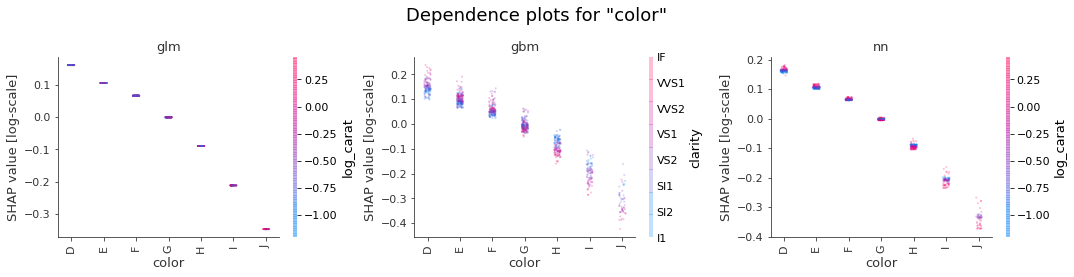

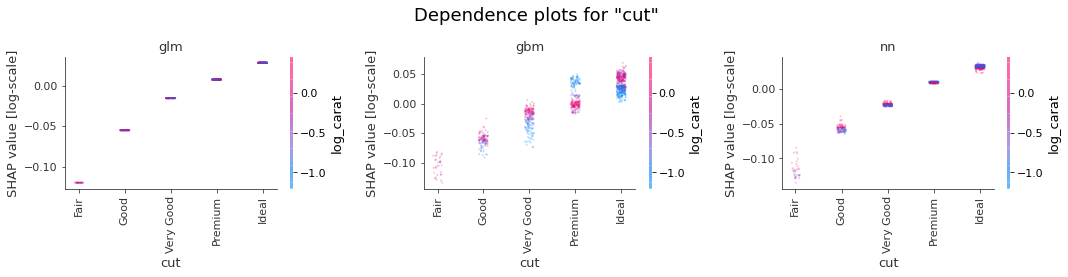

In [102]:
m = len(shap_values)

# Order by GBM importance
sorted_cols = X_train.columns[np.argsort(-np.abs(shap_values['gbm']).mean(0))]

for name in sorted_cols:
    fig, ax = plt.subplots(1, m, figsize=(5 * m, 4))
    for i, key in enumerate(shap_values):
        shap.dependence_plot(name, 
                             shap_values=shap_values.get(key),
                             features=X_train[:N_SHAP], 
                             display_features=X_train_display[:N_SHAP], 
                             alpha=0.25, dot_size=4, x_jitter=0.2, 
                             show=False, 
                             title=key, 
                             ax=ax[i])
        ax[i].set_ylabel('SHAP value [log-scale]')
    fig.suptitle(f'Dependence plots for "{name}"', fontsize=18)
    fig.show()
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])